In [2]:
import pandas as pd
from core import med_log_odds_cutoff, bw_color_palette
from tqdm import tqdm
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
cluster_df = pd.read_table('../data/ecoli/interim/seq_clusters.txt', names=['cluster_id', 'product_accession'])

## Analayze Defense Finder Results

### Skip next three cells

In [13]:
df_top_f = '../data/ecoli/interim/defense_finder_results/'
assemblies = [x for x in os.listdir(df_top_f) if 'GCF' in x]
system_df_list = list()
homolog_df_list = list()
for assembly in tqdm(assemblies):
    df_system_df = pd.read_table(os.path.join(df_top_f, assembly, 'defense_finder_genes.tsv'))
    df_system_df['assembly_stub'] = assembly
    df_homolog_df = pd.read_table(os.path.join(df_top_f, assembly, 'defense_finder_hmmer.tsv'))
    df_homolog_df['assembly_stub'] = assembly
    system_df_list.append(df_system_df)
    homolog_df_list.append(df_homolog_df)

100%|██████████| 3000/3000 [04:47<00:00, 10.42it/s]


In [14]:
cat_system_df = pd.concat(system_df_list)
cat_homolog_df = pd.concat(homolog_df_list)

In [15]:
cat_system_df.to_csv('../data/ecoli/interim/defense_finder_full_systems_genes.csv', index=False)
cat_homolog_df.to_csv('../data/ecoli/interim/defense_finder_homologs.csv', index=False)

### End skip

In [5]:
cat_system_df = pd.read_csv('../data/ecoli/interim/defense_finder_full_systems_genes.csv')
cat_homolog_df = pd.read_csv('../data/ecoli/interim/defense_finder_homologs.csv')

In [6]:
assembly_df_summary = (cat_system_df.groupby('assembly_stub')
                       .agg(n_systems=('sys_id', 'nunique'), 
                                         n_genes=('hit_id', 'nunique'))
                       .reset_index())

In [7]:
cat_system_df['sys_name'] = cat_system_df['gene_name'].str.split('__', expand=True)[0]


In [8]:
system_summary = (cat_system_df.groupby('sys_name')
                  .agg(n_assemblies=('assembly_stub', 'nunique'))
                  .reset_index()
                  .sort_values('n_assemblies', ascending=False))
system_summary.head()

,sys_name,n_assemblies
90,RM_Type_IV,1900
53,Mok_Hok_Sok,1416
70,PD-T4-3,548
55,Mokosh_TypeII,545
88,RM_Type_IIG,514


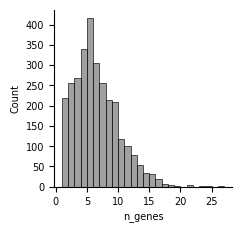

In [9]:
plt.subplots(figsize=(2.3,2.3))
sns.histplot(data=assembly_df_summary, x='n_genes', binwidth=1, color='grey')
sns.despine()

In [10]:
cat_homolog_df

,hit_id,replicon,position_hit,hit_sequence_length,gene_name,assembly_stub
0,WP_000007095.1,UserReplicon,29,455,Hachiman__HamB,GCF_000267385
1,WP_000007095.1,UserReplicon,29,455,Shango__SngC,GCF_000267385
2,WP_000007095.1,UserReplicon,29,455,PsyrTA__PsyrT,GCF_000267385
3,WP_000014594.1,UserReplicon,61,70,Retron_V__CSD,GCF_000267385
4,WP_000020744.1,UserReplicon,91,301,Eleos__LeoA,GCF_000267385
...,...,...,...,...,...,...
799424,WP_236927824.1,UserReplicon,5192,495,DRT8__DRT8,GCF_001893455
799425,WP_236927824.1,UserReplicon,5192,495,DRT_3__drt3b,GCF_001893455
799426,WP_251991158.1,UserReplicon,5198,183,RM__Type_I_S,GCF_001893455
799427,WP_251991158.1,UserReplicon,5198,183,PrrC__EcoprrI,GCF_001893455


In [11]:
unique_homolog_df = (cat_homolog_df.groupby(['hit_id','assembly_stub'])
                     .sample(n=1, random_state=7))

In [12]:
unique_system_df = (cat_system_df.sort_values('sys_score', ascending=False)
                    .groupby(['assembly_stub', 'hit_id'])
                    .head(1))

## Analyze Defense Predictor Results

#### Skip the next four cells

In [39]:
def_pred_top = '../data/ecoli/processed/ecoli_predictions/'
def_pred_fs = [x for x in os.listdir(def_pred_top) if '.csv' in x]

In [41]:
def_pred_list = list()
for f in tqdm(def_pred_fs, position=0):
    pred_df = pd.read_csv(os.path.join(def_pred_top, f))
    def_pred_list.append(pred_df)

100%|██████████| 3000/3000 [08:35<00:00,  5.82it/s]


In [42]:
cat_def_pred = pd.concat(def_pred_list)

In [ ]:
cat_def_pred.to_csv('../data/ecoli/processed/all_predictions.csv', index=False)

#### End skip

In [13]:
%%time
cat_def_pred = pd.read_csv('../data/ecoli/processed/all_predictions.csv')

<timed exec>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 49.1 s, sys: 6.21 s, total: 55.3 s
Wall time: 55.8 s


In [14]:
cat_def_pred['log_odds'] = np.log(cat_def_pred['beaker_prediction']/(1-cat_def_pred['beaker_prediction']))
cat_def_pred['predicted_defensive'] = cat_def_pred['log_odds'] > med_log_odds_cutoff

In [15]:
cat_def_pred['predicted_defensive'].sum()

120010

In [16]:
pred_summary = (cat_def_pred.query('predicted_defensive')
                .groupby('assembly')
                .agg(n_pred_defense=('product_accession', 'nunique'))
                .reset_index())

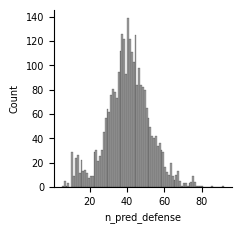

In [17]:
plt.subplots(figsize=(2.3,2.3))
sns.histplot(data=pred_summary, x='n_pred_defense', binwidth=1, color='grey')
sns.despine()

In [18]:
cat_def_pred['assembly_stub'] = cat_def_pred['assembly'].str.split('.', expand=True)[0]

## Analyze overlap

In [19]:
merged_predictions = (cat_def_pred.merge(unique_homolog_df[['hit_id', 'gene_name', 'assembly_stub']]
                                         .rename(columns={'hit_id': 'product_accession', 
                                                          'gene_name': 'defense_homolog_name'}),
                                        how='left', on=['product_accession', 'assembly_stub']))
merged_predictions['defense_homolog'] = ~merged_predictions['defense_homolog_name'].isna()
merged_predictions = (merged_predictions.merge(unique_system_df[['assembly_stub', 'hit_id','gene_name', 'sys_id']]
                                               .rename(columns={'hit_id': 'product_accession', 
                                                                'gene_name': 'defense_system_gene', 
                                                                'sys_id': 'defense_system'}), 
                                               how='left', on=['product_accession', 'assembly_stub']))
merged_predictions['defense_system_protein'] = ~merged_predictions['defense_system_gene'].isna()
merged_predictions = (merged_predictions.merge(cluster_df, how='inner', on='product_accession'))

In [20]:
len(merged_predictions) == len(cat_def_pred)

True

In [21]:
def assign_predicted_category(row):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    else:
        return 'Putative novel defense gene'

In [22]:
predicted_defense_df = merged_predictions[merged_predictions['predicted_defensive'] |
                                          merged_predictions['defense_system_protein']].copy()
predicted_defense_df['predicted_category'] = predicted_defense_df.apply(assign_predicted_category, axis=1)

In [23]:
predicted_defense_df['predicted_category'].value_counts()

predicted_category
Defense homolog in new context        63311
Putative novel defense gene           42645
Defense homolog in expected system    17876
Name: count, dtype: int64

In [24]:
(predicted_defense_df.groupby('predicted_category')
                      .agg(n_unique_clusters=('cluster_id', 'nunique'))
                      .reset_index())

,predicted_category,n_unique_clusters
0,Defense homolog in expected system,925
1,Defense homolog in new context,1497
2,Putative novel defense gene,1981


In [25]:
predicted_defense_df.loc[predicted_defense_df['predicted_category'] == 'Putative novel defense gene', 'name'].value_counts().head(20)

name
hypothetical protein                                          18372
clamp-binding protein CrfC                                     2667
type II toxin-antitoxin system RelE/ParE family toxin          2632
DUF4132 domain-containing protein YehI                         1640
type II toxin-antitoxin system mRNA interferase toxin YafQ     1549
dynamin family protein                                         1376
type II toxin-antitoxin system toxin HigB                      1354
protein YehK                                                   1251
WGR and DUF4132 domain-containing protein                       871
type II toxin-antitoxin system HigB family toxin                794
DUF262 domain-containing protein                                570
restriction endonuclease                                        488
response regulator receiver domain                              470
DUF2971 domain-containing protein                               453
ATP-binding protein                        

In [26]:
genomes = predicted_defense_df['assembly'].drop_duplicates()

In [27]:
sample_range = [int(x) for x in np.linspace(1, 3_000, num=50)]
n_def_cluster_list = list()
for n in tqdm(sample_range):
    sampled_genomes = genomes.sample(n=n, random_state=7)
    sampled_def_df = predicted_defense_df[predicted_defense_df['assembly'].isin(sampled_genomes)]
    n_def_clusters = (sampled_def_df.groupby('predicted_category')
                      .agg(n_unique_clusters=('cluster_id', 'nunique'))
                      .reset_index())
    n_def_clusters['n_genomes'] = n
    n_def_cluster_list.append(n_def_clusters)
cat_n_def_cluster = pd.concat(n_def_cluster_list)

100%|██████████| 50/50 [00:02<00:00, 21.73it/s]


In [28]:
cat_n_def_cluster['predicted_category'] = pd.Categorical(cat_n_def_cluster['predicted_category'], 
                                                         categories=['Defense homolog in expected system', 
                                                                    'Defense homolog in new context', 
                                                                    'Putative novel defense gene'])

Text(0.5, 0, '# Genomes')

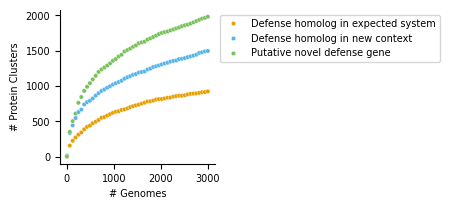

In [29]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=cat_n_def_cluster, x='n_genomes', y='n_unique_clusters', hue='predicted_category',
              palette=bw_color_palette[:2] + ['#78C15B'], s=10)
sns.despine()
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.ylabel('# Protein Clusters')
plt.xlabel('# Genomes')

In [108]:
selected_novel_proteins = (predicted_defense_df[predicted_defense_df['predicted_category'] == 'Putative novel defense gene']
                           .sort_values('log_odds', ascending=False)
                           .groupby('cluster_id')
                           .head(1))

In [118]:
selected_novel_proteins['name'].value_counts().head(20)

name
hypothetical protein                                     1265
DUF2971 domain-containing protein                          31
restriction endonuclease                                   28
HEPN domain-containing protein                             25
ATP-binding protein                                        25
restriction endonuclease subunit S                         24
AAA family ATPase                                          21
DUF262 domain-containing protein                           18
HNH endonuclease                                           17
DUF4365 domain-containing protein                          15
nucleoid-associated protein                                15
PIN domain-containing protein                              15
type II toxin-antitoxin system RelE/ParE family toxin      15
DUF4145 domain-containing protein                          14
P-loop NTPase fold protein                                 14
SMEK domain-containing protein                             13
HNH

In [120]:
novel_acc_out = '../data/ecoli/interim/selected_novel_accessions.txt'


In [122]:
selected_novel_proteins['product_accession'].to_csv(novel_acc_out, index=False, header=False)

In [123]:
faa_out = '../data/ecoli/interim/selected_novel_seqs.faa'


In [126]:
os.system(' '.join(['conda run -n beaker', 
                    'seqtk subseq', '../data/ecoli/interim/unique_seqs.faa', 
                    novel_acc_out, '>',
                    faa_out]))

0

In [30]:
predicted_defense_df.to_csv('../data/ecoli/interim/predicted_defense_df.csv', index=False)

In [ ]:
merged_predictions.to_csv('../data/ecoli/processed/ecoli_predictions_annot.csv', index=False)
selected_novel_proteins.to_csv('../data/ecoli/interim/selected_novel_genes.csv', index=False)


In [1]:
import pandas as pd

In [3]:
ecoli_predictions_annot = pd.read_csv('../data/ecoli/processed/ecoli_predictions_annot.csv')

/state/partition1/slurm_tmp/27555002.0.0/ipykernel_297213/3646420519.py:1: DtypeWarning: Columns (7,21,25,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  ecoli_predictions_annot = pd.read_csv('../data/ecoli/processed/ecoli_predictions_annot.csv')


In [4]:
ecoli_predictions_annot.head()

,protein_context_id,beaker_prediction,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,...,attributes,log_odds,predicted_defensive,assembly_stub,defense_homolog_name,defense_homolog,defense_system_gene,defense_system,defense_system_protein,cluster_id
0,WP_001568552.1|NZ_JAIHLJ010000004.1|11426|+,1.0,CDS,with_protein,GCF_020668315.1,Primary Assembly,unplaced scaffold,NaN,NZ_JAIHLJ010000004.1,11426,...,NaN,29.469973,True,GCF_020668315,Thoeris_I__ThsA_new_grand,True,NaN,NaN,False,WP_040088523.1
1,WP_000177023.1|NZ_JAIHLJ010000011.1|94902|+,1.0,CDS,with_protein,GCF_020668315.1,Primary Assembly,unplaced scaffold,NaN,NZ_JAIHLJ010000011.1,94902,...,NaN,24.733916,True,GCF_020668315,RM_Type_IV__Type_IV_REases,True,RM_Type_IV__Type_IV_REases,UserReplicon_RM_Type_IV_1,True,WP_028120629.1
2,WP_000177023.1|NZ_NNZI01000001.1|333234|+,1.0,CDS,with_protein,GCF_002547485.1,Primary Assembly,unplaced scaffold,NaN,NZ_NNZI01000001.1,333234,...,NaN,23.739626,True,GCF_002547485,RM_Type_IV__Type_IV_REases,True,RM_Type_IV__Type_IV_REases,UserReplicon_RM_Type_IV_1,True,WP_028120629.1
3,WP_000177023.1|NZ_NNYC01000011.1|108831|+,1.0,CDS,with_protein,GCF_002546565.1,Primary Assembly,unplaced scaffold,NaN,NZ_NNYC01000011.1,108831,...,NaN,23.476266,True,GCF_002546565,RM_Type_IV__Type_IV_REases,True,RM_Type_IV__Type_IV_REases,UserReplicon_RM_Type_IV_2,True,WP_028120629.1
4,WP_000177023.1|NZ_LOGI01000090.1|89534|+,1.0,CDS,with_protein,GCF_001607155.1,Primary Assembly,unplaced scaffold,NaN,NZ_LOGI01000090.1,89534,...,NaN,23.687221,True,GCF_001607155,RM_Type_IV__Type_IV_REases,True,RM_Type_IV__Type_IV_REases,UserReplicon_RM_Type_IV_2,True,WP_028120629.1
